<a href="https://colab.research.google.com/github/BernieT7/ML/blob/main/%E8%87%AA%E8%A3%BDdataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 下載網址
!pip install wget
import wget

wget.download("https://github.com/GrandmaCan/ML/raw/main/Classification/one_piece_mini.zip")

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=2de873dd645fc48e720eeb64fb69289105e9e5720dac9fa37d5dd56a795956e3
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


'one_piece_mini.zip'

In [ ]:
# 解壓縮(zip檔)
import zipfile

with zipfile.ZipFile("one_piece_mini.zip", "r") as zip_ref:
  zip_ref.extractall("one_peace_mini")

In [ ]:
# 建立一個dataset的類別
from torch.utils.data import Dataset
from pathlib import Path
from PIL import Image                                  # 此套件可以為我們畫出圖片
from torchvision import transforms

class OnePieceDataset(Dataset):
  def __init__(self, root, train, transform=None):
    if train:                                     # 判斷現在要的是測試集還是訓練集
      image_root = Path(root) / "train"                     # 訓練集路徑
    else:
      image_root = Path(root) / "test"                      # 測試集路徑

    with open(Path(root) / "classnames.txt", "r") as f:             # 讀取classes也就是我們的y
      lines = f.readlines()
      self.classes = [line.strip() for line in lines]             # 這樣寫會把原本有的\n刪掉

    self.paths = [i for i in image_root.rglob("*") if i.is_file()]       # rglob("*")可以取得image_root之後的所有資料。
                                              # is_file只要圖片檔不要資料夾
    self.transform = transform

  def __getitem__(self, index):
    img = Image.open(self.paths[index]).convert("RGB")                # .open畫出圖片.convert轉換圖片格式
    class_name = self.paths[index].parent.name                    # 可以取得前一個資料夾(classes)名稱
    class_idx = self.classes.index(class_name)                    # 可以取得各classes名稱所對應的index

    if self.transform:
      return self.transform(img), class_idx
    else:
      return img, class_idx

  def __len__(self):
    return len(self.paths)

In [ ]:
# resize = transforms.Resize((64, 64))                        # 轉換原圖片大小
                                             # Docs > Transforming and augmenting images > Resize
# totensor = transforms.ToTensor()                           # 轉換成tensor格式
                                             # Docs > Transforming and augmenting images > ToTensor

train_transforms = transforms.Compose([                         # transforms.Compose([])可以把許多轉換動作組裝
    transforms.Resize((64, 64)),
    transforms.TrivialAugmentWide(),                         # 數據增強data augmentation
                                             # Docs > Transforming and augmenting images > TrivialAugmentWide
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [ ]:
train_dataset = OnePieceDataset("one_peace_mini", train=True, transform=train_transforms)
train_dataset.classes
x, y = train_dataset[123]
x, y

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 2)

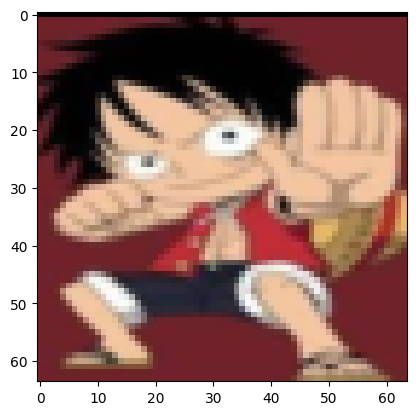

In [ ]:
import matplotlib.pyplot as plt

x, y = train_dataset[7]
plt.imshow(x.permute(1, 2, 0))

In [ ]:
train_dataset = OnePieceDataset(root="one_peace_mini",
                  train=True,
                  transform=train_transforms
)

test_dataset = OnePieceDataset(root="one_peace_mini",
                  train=False,
                  transform=test_transforms
)

In [ ]:
x, y = test_dataset[0]
x.shape, y

(torch.Size([3, 64, 64]), 0)

In [ ]:
len(train_dataset), len(test_dataset)

(240, 60)

In [ ]:
from torch.utils.data import DataLoader

BATCH_SIZE = 8

train_dataloader = DataLoader(dataset=train_dataset,
              batch_size=BATCH_SIZE,
              shuffle=True
)

test_dataloader = DataLoader(dataset=test_dataset,
              batch_size=BATCH_SIZE,
              shuffle=False
)

In [ ]:
len(train_dataloader), len(test_dataloader)

(30, 8)

In [ ]:
x_first_batch, y_first_batch = next(iter(train_dataloader))
x_first_batch.shape, y_first_batch[0]

(torch.Size([8, 3, 64, 64]), tensor(2))

In [ ]:
from torch import nn

class ImageClassificationModel3(nn.Module):                    # 創建模型類別
  def __init__(self, input_shape, output_shape):                #初始化
    super().__init__()
    self.block_1 = nn.Sequential(
      nn.Conv2d(in_channels=input_shape,
          out_channels=8,
          kernel_size=(3, 3),
          stride=1,
          padding=1
      ),
      nn.ReLU(),
      nn.Conv2d(in_channels=8,
          out_channels=8,
          kernel_size=(3, 3),
          stride=1,
          padding=1
      ),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=(2, 2),
            stride=2,
            padding=0
      )
    )
    self.block_2 = nn.Sequential(
      nn.Conv2d(in_channels=8,
          out_channels=16,
          kernel_size=(3, 3),
          stride=1,
          padding=1
      ),
      nn.ReLU(),
      nn.Conv2d(in_channels=16,
          out_channels=16,
          kernel_size=(3, 3),
          stride=1,
          padding=1
      ),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=(2, 2),
            stride=2,
            padding=0
      )
    )
    self.classifier = nn.Sequential(
      nn.Flatten(start_dim=1, end_dim=-1),
      nn.Linear(in_features=16 * 16 * 16, out_features=output_shape)
    )

  def forward(self, x):                             # forward函數
    return self.classifier(self.block_2(self.block_1(x)))

In [ ]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
model = ImageClassificationModel3(input_shape=3, output_shape=len(train_dataset.classes))
model.to(device)
model(x_first_batch.to(device))

tensor([[-0.0262, -0.0199, -0.0013],
        [-0.0447, -0.0577, -0.0082],
        [-0.0476, -0.0289, -0.0153],
        [-0.0353, -0.0362,  0.0016],
        [-0.0434, -0.0194, -0.0040],
        [-0.0444, -0.0176, -0.0208],
        [-0.0209, -0.0361,  0.0083],
        [-0.0230, -0.0260, -0.0097]], grad_fn=<AddmmBackward0>)

In [ ]:
cost_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)             # 這次以Adam作為optimizer，Adam與SGD的不同在於Adam的學習率會改變

In [ ]:
def accuracy_fn(y_pred, y_true):

  correct_num = (y_pred==y_true).sum()
  acc = correct_num / len(y_true) * 100

  return acc

In [ ]:
def train_step(dataloader, model, cost_fn, optimizer, accuracy_fn, device):
  train_cost = 0
  train_acc = 0
  for batch, (x, y) in enumerate(dataloader):
    x = x.to(device)
    y = y.to(device)

    model.train()

    y_pred = model(x)

    cost = cost_fn(y_pred, y)

    train_cost += cost
    train_acc += accuracy_fn(y_pred.argmax(dim=1), y)

    optimizer.zero_grad()

    cost.backward()

    optimizer.step()

  train_cost /= len(train_dataloader)
  train_acc /= len(train_dataloader)

  print(f"\nTrain Cost: {train_cost:.4f}, Train Acc: {train_acc:.2f}")


def test_step(dataloader, model, cost_fn, accuracy_fn, device):
  test_cost = 0
  test_acc = 0
  model.eval()
  with torch.inference_mode():
    for x, y in dataloader:
      x = x.to(device)
      y = y.to(device)

      test_pred = model(x)

      test_cost += cost_fn(test_pred, y)
      test_acc += accuracy_fn(test_pred.argmax(dim=1), y)

    test_cost /= len(test_dataloader)
    test_acc /= len(test_dataloader)

  print(f"Test Cost: {test_cost:.4f}, Test Acc: {test_acc:.2f} \n")

In [ ]:
from tqdm.auto import tqdm

epochs = 10

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n-------")

  train_step(train_dataloader, model, cost_fn, optimizer, accuracy_fn, device)

  test_step(test_dataloader, model, cost_fn, accuracy_fn, device)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
-------

Train Cost: 0.5116, Train Acc: 78.33
Test Cost: 0.5454, Test Acc: 79.69 

Epoch: 1
-------

Train Cost: 0.4906, Train Acc: 84.17
Test Cost: 0.5349, Test Acc: 79.69 

Epoch: 2
-------

Train Cost: 0.4459, Train Acc: 84.17
Test Cost: 0.5427, Test Acc: 81.25 

Epoch: 3
-------

Train Cost: 0.4589, Train Acc: 82.92
Test Cost: 0.6910, Test Acc: 71.88 

Epoch: 4
-------

Train Cost: 0.4220, Train Acc: 84.58
Test Cost: 0.5788, Test Acc: 79.69 

Epoch: 5
-------

Train Cost: 0.4655, Train Acc: 82.92
Test Cost: 0.5933, Test Acc: 76.56 

Epoch: 6
-------

Train Cost: 0.4558, Train Acc: 82.50
Test Cost: 0.5277, Test Acc: 82.81 

Epoch: 7
-------

Train Cost: 0.4731, Train Acc: 80.00
Test Cost: 0.5511, Test Acc: 75.00 

Epoch: 8
-------

Train Cost: 0.4739, Train Acc: 83.75
Test Cost: 0.5537, Test Acc: 78.12 

Epoch: 9
-------

Train Cost: 0.4923, Train Acc: 78.75
Test Cost: 0.4939, Test Acc: 84.38 



In [ ]:
# 實際應用的圖片也要照著當初訓練模型時處理圖片的方式去處理(格式、 大小等等...)

img = Image.open("luffy.jpg").convert("RGB")
img = test_transforms(img)
img = img.reshape(-1, 3, 64, 64)            # 因為這張圖片的shape少了batch的維度所以要reshape
model.eval()
with torch.inference_mode():
  y_pred = model(img.to(device))
y_pred = torch.softmax(y_pred, dim=1)
class_idx = y_pred.argmax(dim=1)
train_dataset.classes[class_idx]

'Luffy'

In [ ]:
import requests

url = "https://firebasestorage.googleapis.com/v0/b/grandmacan-2dae4.appspot.com/o/ML_data%2Fone_piece_full.zip?alt=media&token=937656fd-f5c1-44f5-b174-1e2d590b8ef3"

with open("one_piece_full.zip", "wb") as f:
  req = requests.get(url)
  f.write(req.content)

In [ ]:
import zipfile

with zipfile.ZipFile("one_piece_full.zip", "r") as zip_ref:
  zip_ref.extractall("one_peace_full")

In [ ]:
train_dataset = OnePieceDataset(root="one_peace_full",
                train=True,
                transform=train_transforms
)

test_dataset = OnePieceDataset(root="one_peace_full",
                train=False,
                transform=test_transforms
)

In [ ]:
len(train_dataset), len(test_dataset)

(3015, 750)

In [ ]:
from torch.utils.data import DataLoader

BATCH_SIZE = 16

train_dataloader = DataLoader(dataset=train_dataset,
                batch_size=BATCH_SIZE,
                shuffle=True
)

test_dataloader = DataLoader(dataset=test_dataset,
                batch_size=BATCH_SIZE,
                shuffle=False
)

In [ ]:
len(train_dataloader), len(test_dataloader)

(189, 47)

In [ ]:
model_2 = ImageClassificationModel3(3, len(train_dataset.classes))
model_2.to(device)

ImageClassificationModel3(
  (block_1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4096, out_features=18, bias=True)
  )
)

In [ ]:
cost_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_2.parameters(), lr=0.001)

In [ ]:
from tqdm.auto import tqdm

epochs = 10

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n-------")

  train_step(train_dataloader, model_2, cost_fn, optimizer, accuracy_fn, device)

  test_step(test_dataloader, model_2, cost_fn, accuracy_fn, device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
-------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



Train Cost: 2.8845, Train Acc: 6.36
Test Cost: 2.8536, Test Acc: 12.37 

Epoch: 1
-------

Train Cost: 2.7904, Train Acc: 11.33
Test Cost: 2.6191, Test Acc: 17.15 

Epoch: 2
-------

Train Cost: 2.6664, Train Acc: 16.78
Test Cost: 2.4732, Test Acc: 24.62 

Epoch: 3
-------

Train Cost: 2.5663, Train Acc: 20.99
Test Cost: 2.4376, Test Acc: 23.90 

Epoch: 4
-------


KeyboardInterrupt: 